In [18]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

# Load environment variables
load_dotenv()
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')

# Initialize BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

# Get ophys experiments
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load Transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"
with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

movie_one = transfr['natural_movie_one']

embeddings=movie_one[:,0]

experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

stim_table = data_set_regression.get_stimulus_table('natural_movie_one')
ts = stim_table[stim_table['repeat'] == 0]['start'].values

neuron=data_set_events[6,ts]
# Partition the embeddings into 5 levels based on quantiles
quantiles = np.percentile(embeddings, [20, 40, 60, 80])
bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
levels = np.digitize(embeddings, bins) - 1  # Levels from 0 to 4
print(embeddings.shape)

event_values_per_level = []
for level in range(5):
    indices = np.where(levels == level)[0]
    event_values = neuron[indices]
    event_values_per_level.append(event_values)

event_values_per_level = np.array(event_values_per_level) 
print(event_values_per_level.shape)
#print(event_values_per_level)

event_values_nonzero=np.count_nonzero(event_values_per_level, axis=1)
event_values_nonzero

(900,)
(5, 180)


array([4, 1, 1, 3, 4])

(array([[0., 5., 0., 2., 0., 2., 1., 0., 0., 0.],
        [0., 4., 0., 2., 0., 1., 1., 0., 2., 0.],
        [1., 4., 0., 2., 0., 1., 2., 0., 0., 0.],
        [0., 1., 0., 3., 0., 4., 0., 0., 1., 1.],
        [1., 2., 0., 1., 0., 4., 1., 0., 0., 1.]]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 5 BarContainer objects>)

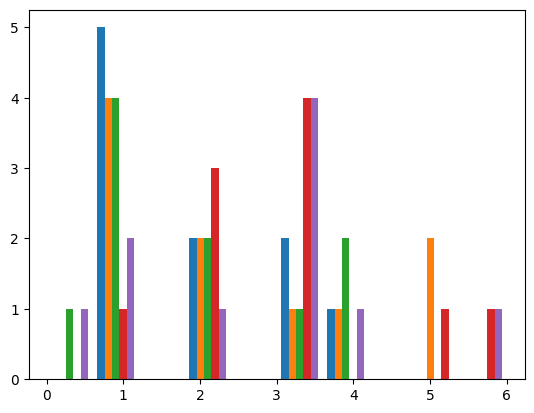

In [22]:
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import os
import pickle

# Load environment variables
load_dotenv()
allen_cache_path = os.environ.get('HGMS_ALLEN_CACHE_PATH')

# Initialize BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=str(Path(allen_cache_path) / Path('brain_observatory_manifest.json')))

# Get ophys experiments
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[511511001])

# Load Transformer embeddings
file_path = "/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/google_vit-base-patch16-224-in21k_embeddings.pkl"
with open(file_path, 'rb') as file:
    transfr = pickle.load(file)

stimuli = transfr['natural_movie_one']

experiment_id = 506278598
data_set_regression = boc.get_ophys_experiment_data(experiment_id)
data_set_events = boc.get_ophys_experiment_events(experiment_id)

stim_table = data_set_regression.get_stimulus_table('natural_movie_one')

def generate_event_count_vector_levels(trial_ind, neuron_ind, transformer_emb_ind):
    ts = stim_table[stim_table['repeat'] == trial_ind]['start'].values
    neuron=data_set_events[neuron_ind,ts]
    embeddings = stimuli[:,transformer_emb_ind]
    # Partition the embeddings into 5 levels based on quantiles
    quantiles = np.percentile(embeddings, [20, 40, 60, 80])
    bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
    levels = np.digitize(embeddings, bins) - 1 

    event_values_per_level = []
    for level in range(5):
        indices = np.where(levels == level)[0]
        event_values = neuron[indices]
        event_values_per_level.append(event_values)

    event_values_per_level = np.array(event_values_per_level)
    event_values_nonzero=np.count_nonzero(event_values_per_level, axis=1)

    return event_values_nonzero

neuron_trial_counts=[]

for trial in range(10):
    neuron_trial_counts.append(generate_event_count_vector_levels(trial, 6, 0))

neuron_trial_counts=np.array(neuron_trial_counts)

plt.hist(neuron_trial_counts)

In [35]:
print(stimuli.shape)

(900, 768)


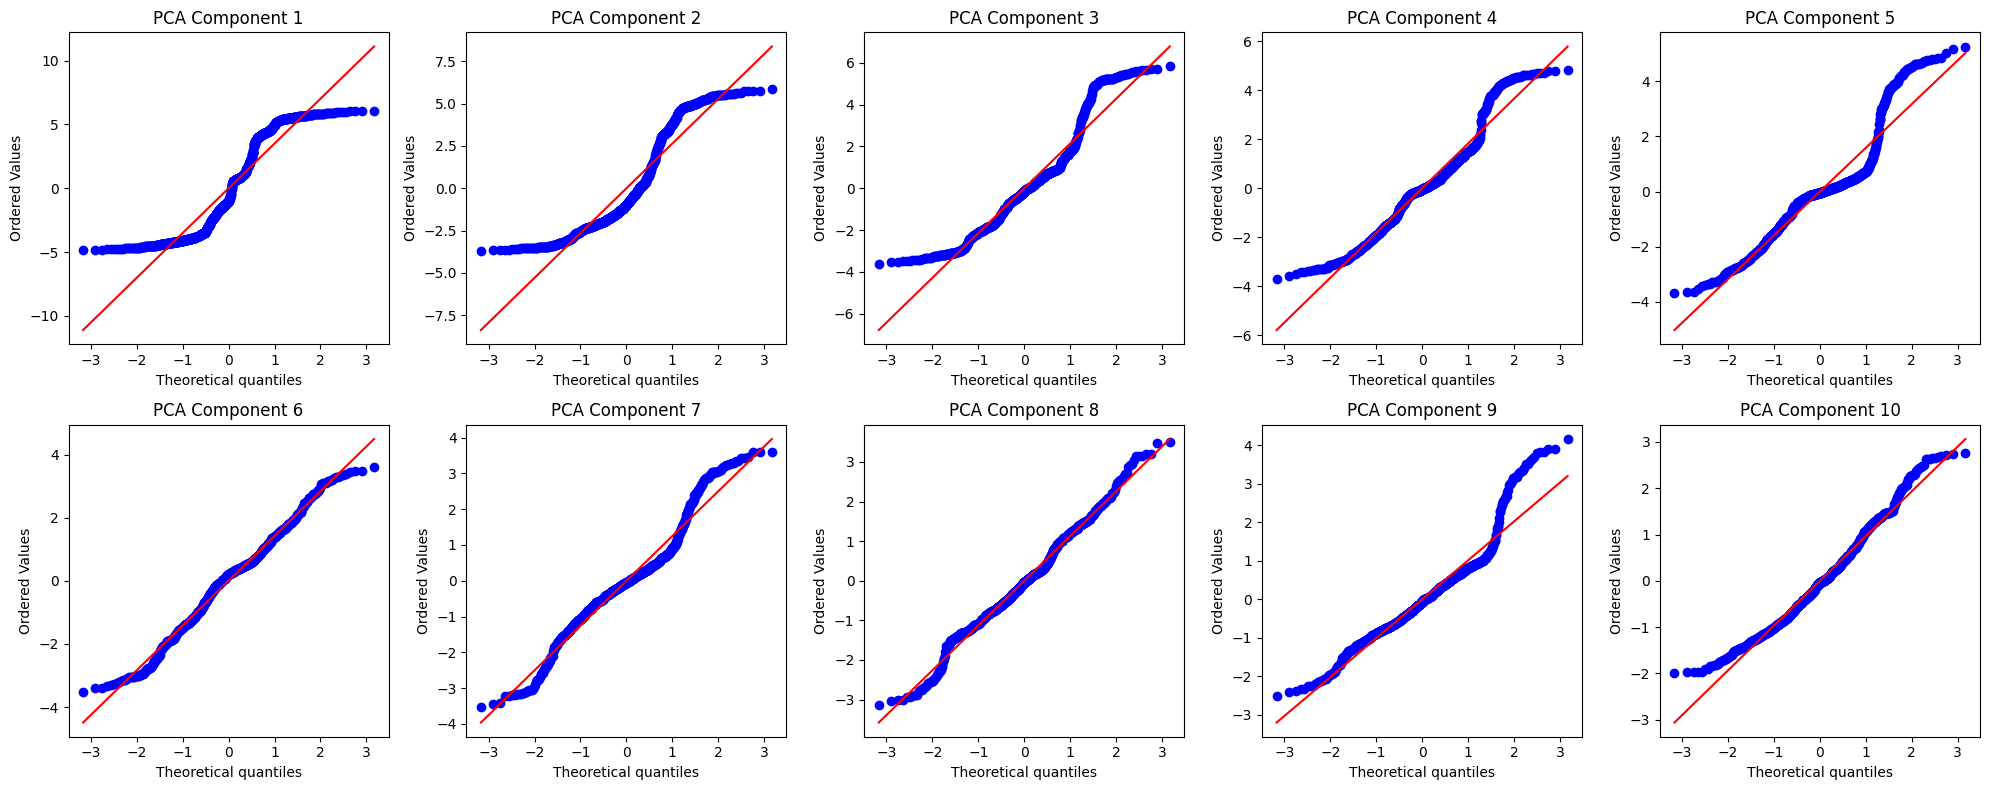

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import probplot

# Assuming movie_one is a NumPy array with shape (900, 768)
# Replace this with your actual data loading method if needed
# movie_one = np.load('path_to_movie_one.npy')  # Example of loading data

# Perform PCA to reduce the embedding dimensions from 768 to 10
n_components = 10
pca = PCA(n_components=n_components)
pca_scores = pca.fit_transform(movie_one)  # Shape: (900, 10)

# Now pca_scores is a NumPy array with shape (900, 10),
# where each column corresponds to one of the top 10 principal components

# Generate QQ-plots for each of the 10 principal components
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
axes = axes.flatten()

for i in range(n_components):
    ax = axes[i]
    data = pca_scores[:, i]
    probplot(data, dist="norm", plot=ax)
    ax.set_title(f"PCA Component {i + 1}")

plt.tight_layout()
plt.show()


In [27]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare the data
data = []
for trial_index in range(neuron_trial_counts.shape[0]):
    for level_index in range(neuron_trial_counts.shape[1]):
        count = neuron_trial_counts[trial_index, level_index]
        data.append({
            'Count': count,
            'Level': level_index,
            'Trial': trial_index
        })

df = pd.DataFrame(data)

# Fit Poisson regression model
model = smf.glm(formula='Count ~ C(Level)', data=df, family=sm.families.Poisson()).fit()

print(model.summary())

# Test the significance of the levels
if model.pvalues['C(Level)[T.1]'] < 0.05 or \
   model.pvalues['C(Level)[T.2]'] < 0.05 or \
   model.pvalues['C(Level)[T.3]'] < 0.05 or \
   model.pvalues['C(Level)[T.4]'] < 0.05:
    print("At least one level significantly predicts neuron event counts.")
else:
    print("Levels do not significantly predict neuron event counts.")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   50
Model:                            GLM   Df Residuals:                       45
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85.744
Date:                Tue, 03 Dec 2024   Deviance:                       43.364
Time:                        20:38:55   Pearson chi2:                     41.3
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07372
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6419      0.229      2.798

In [30]:
import numpy as np
from scipy.stats import chi2_contingency

# Contingency table
contingency_table = neuron_trial_counts

# Perform chi-squared test with Monte Carlo simulation
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table, lambda_="log-likelihood", correction=False)

print(f"P-value from chi-squared test: {p_value}")

# Note: For exact p-values with small counts, you can perform permutation tests
# Here is an example of a permutation test using custom code

def permutation_test(cont_table, num_permutations=10000):
    observed_stat = chi2_stat
    count_rows, count_cols = cont_table.shape
    total_counts = np.sum(cont_table)
    flat_counts = cont_table.flatten()
    
    more_extreme = 0
    for _ in range(num_permutations):
        shuffled_counts = np.random.permutation(flat_counts)
        permuted_table = shuffled_counts.reshape((count_rows, count_cols))
        perm_chi2_stat, _, _, _ = chi2_contingency(permuted_table, lambda_="log-likelihood", correction=False)
        if perm_chi2_stat >= observed_stat:
            more_extreme += 1
    p_value_perm = more_extreme / num_permutations
    return p_value_perm

p_value_perm = permutation_test(contingency_table)
print(f"P-value from permutation test: {p_value_perm}")

if p_value_perm < 0.05:
    print("Reject the null hypothesis: There is a significant association between levels and event counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between levels and event counts.")


P-value from chi-squared test: 0.4131462680023486
P-value from permutation test: 0.3147
Fail to reject the null hypothesis: No significant association between levels and event counts.


In [32]:
from scipy.stats import kruskal

# Extract counts per level
counts_per_level = [neuron_trial_counts[:, i] for i in range(neuron_trial_counts.shape[1])]

# Perform Kruskal-Wallis H-test
h_stat, p_value = kruskal(*counts_per_level)

print(f"Kruskal-Wallis H-statistic: {h_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There are significant differences in event counts across levels.")
else:
    print("Fail to reject the null hypothesis: No significant differences in event counts across levels.")


Kruskal-Wallis H-statistic: 3.976703274354269
P-value: 0.4091679000096946
Fail to reject the null hypothesis: No significant differences in event counts across levels.


In [33]:
from scipy.stats import spearmanr

# Prepare data
counts = neuron_trial_counts.flatten()
levels = np.repeat(np.arange(neuron_trial_counts.shape[1]), neuron_trial_counts.shape[0])

# Perform Spearman's rank correlation
corr_coeff, p_value = spearmanr(levels, counts)

print(f"Spearman's correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant correlation between levels and event counts.")
else:
    print("Fail to reject the null hypothesis: No significant correlation between levels and event counts.")
    

Spearman's correlation coefficient: -0.13714305083418923
P-value: 0.3422557311536102
Fail to reject the null hypothesis: No significant correlation between levels and event counts.


In [34]:
from scipy.stats import poisson

# Calculate overall rate
total_counts = np.sum(neuron_trial_counts)
total_trials = neuron_trial_counts.size
overall_rate = total_counts / total_trials

# Perform Poisson test for each level
for i in range(neuron_trial_counts.shape[1]):
    observed_counts = np.sum(neuron_trial_counts[:, i])
    expected_counts = overall_rate * neuron_trial_counts.shape[0]
    p_value = poisson.sf(observed_counts - 1, expected_counts)
    print(f"Level {i}: Observed Counts = {observed_counts}, Expected Counts = {expected_counts}, P-value = {p_value}")


Level 0: Observed Counts = 19, Expected Counts = 23.799999999999997, P-value = 0.8632833968258914
Level 1: Observed Counts = 25, Expected Counts = 23.799999999999997, P-value = 0.42977300257848633
Level 2: Observed Counts = 19, Expected Counts = 23.799999999999997, P-value = 0.8632833968258914
Level 3: Observed Counts = 30, Expected Counts = 23.799999999999997, P-value = 0.12324408703004487
Level 4: Observed Counts = 26, Expected Counts = 23.799999999999997, P-value = 0.3525814851644367


In [37]:
.get_stimulus_template(
        'noise')

NameError: name 'movie_three_dataset' is not defined